<font size="8"> **Calculating distance to nearest sea ice edge grid cell from all grid cells** </font>  
The sea ice edge was defined as the northernmost grid cells with a sea ice concentration of 10\% or more. The distance from each grid cell in the original data to the closest sea ice edge grid cell was calculated.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [3]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

# Loading modules

In [4]:
#Accessing model data
import intake
#Dealing with data
import xarray as xr
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
#Collection of useful functions developed for this project
import UsefulFunctions as uf
#Useful package to deal with file paths
from glob import glob
#Parallelising work
from dask.distributed import Client

# Defining dictionary of useful variables
In this dictionary we will define a variables that will be used multiple times throughout this notebook to avoid repetition. It will mostly contain paths to folders where intermediate or final outputs will be stored.

In [5]:
varDict = {'var_mod': 'aice_m',
           'var_short_name': 'SIC',
           'var_long_name': 'sea ice concentration',
           'model': 'ACCESS-OM2-01',
           'exp': '01deg_jra55v140_iaf_cycle4',
           'exp_ext': '01deg_jra55v140_iaf_cycle4_jra55v150_extension',
           'freq': '1mon',
           'base_folder': '/g/data/vf71//la6889/Chapter2_Crabeaters/SeaIce/Distance_Edge/'}

# Creating a session in the COSIMA cookbook

In [6]:
catalog = intake.cat.access_nri

# Accessing ACCESS-OM2-01 data
First, we will start a cluster with multiple cores to make analysis faster. Remember the number of CPUs cannot exceed the CPUs you have access to.

In [ ]:
client = Client()

We will now access the model outputs. Here, we use monthly sea ice concentration outputs from ACCESS-OM2-01 fourth cycle for these calculations. The experiment name for the original 4th cycle is `01deg_jra55v140_iaf_cycle4` and it covers the period between January 1958 to December 2018. While, experiment `01deg_jra55v140_iaf_cycle4_jra55v150_extension` extends this fourth cycle to December 2022.
  
We are using cycle four because we are interested in examining the relationship between crabeater seal distribution and a variety of environmental variables, including biogeochemical factors (e.g., photosynthetic active radiation or PAR, and chlorophyll concentration). Only the fourth cycle has biogeochemical outputs available. See the [COSIMA website](https://cosima.org.au/index.php/2020/07/29/data-available-0-1-1958-2018-access-om2-iaf-run/) for more information.

In [6]:
#Loading data from fourth cycle (temporal range 1958 to 2018)
var_ice = uf.getACCESSdata_SO(varDict['var_mod'], '1978-01', '2019-01', 
                              freq = varDict['freq'], catalog = catalog, 
                              minlat = -80, exp = varDict['exp'], ice_data = True)
#Loading data from fourth cycle extension (2019 to 2022)
var_ice_ext = uf.getACCESSdata_SO(varDict['var_mod'], '2019-01', '2023-01', 
                                  freq = varDict['freq'], catalog = catalog, 
                                  minlat = -80, exp = varDict['exp_ext'], 
                                  ice_data = True)

## Creating a single dataset for our study period
We need to merge both datasets so we can calculate the long-term presence of pack ice for our entire study period (1978 to 2022).

In [7]:
#Concatenating both data arrays into one
var_ice = xr.concat([var_ice, var_ice_ext], dim = 'time')
var_ice = uf.corrlong(var_ice)

#Removing duplicate variable
del var_ice_ext

# Finding sea ice edge
The sea ice edge is the defined as the northernmost areas where sea ice concentration (SIC) is under $10\%$. This is a multistep process:
1. Identify pixels where SIC is greater or equal to 0.1, and change value to 1,
2. Calculate cumulate sum along y axis,
3. Apply mask to remove original `NaN` values from cumulative sums.

This will result in pixels with the highest value along the y axis to be identified as the sea ice edge. 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/array/reductions.py:649: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/array/reductions.py:649: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


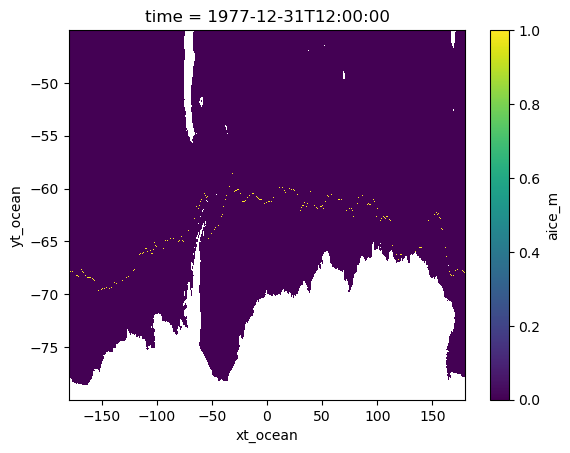

In [8]:
#Assign a value of 1 to any areas where SIC is at least 0.1
ice_10 = xr.where(var_ice >= 0.1, 1, np.nan)

#Adding all cells along y axis. Masking out NA values
ice_10 = ice_10.cumsum(dim = 'yt_ocean', skipna = True).where(~np.isnan(ice_10))

#Finding cells with highest value along y axis. This identifies the ice edge at each longitude.
ice_10 = xr.where(ice_10 == ice_10.max('yt_ocean'), 1, 0).where(~np.isnan(var_ice))

#Checking result for first time step
ice_10.isel(time = 0).plot()

## Checking results in relation to SIC data

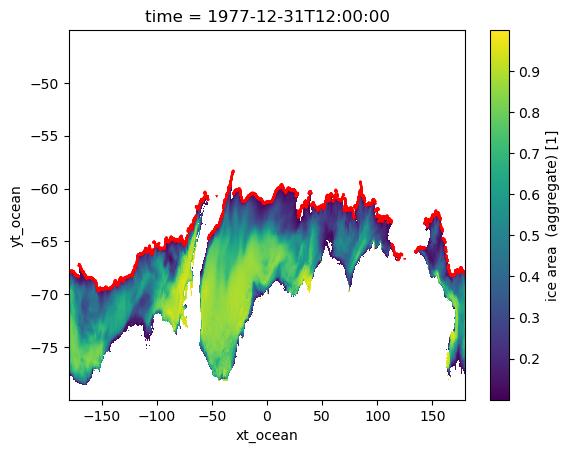

In [10]:
#Checking results for first time step
fig = plt.figure()
ax = fig.add_subplot(111)
var_ice.where(var_ice >= 0.1)[0].plot(ax = ax)
ice_10[0].plot.contour(ax = ax, colors = ['red'])

Above we plotted only pixels with SIC greater or equal to 0.1. The red line represents the sea ice edge we identified in the previous step. We can be satisfied that we identified the sea ice edge correctly.

# Getting coordinate pairs for each cell in the original grid
We will use the latitude and longitude values in our data to create coordinate pairs. We only need to get this information once if we are calculating distances from the same grid.  
  
We also need to transform coordinate pairs to radians as this is needed in the calculation of distances.

In [11]:
#Storing longitude and latitude values
x, y = np.meshgrid(np.deg2rad(var_ice.xt_ocean.values),
                   np.deg2rad(var_ice.yt_ocean.values))

#Changing shape so there are two values per row
grid_coords = np.vstack([y.flat, x.flat]).T

#Removing variables not needed
del x, y

# Calculating distance to closest sea ice edge cell
In the `UsefulFuctions` script there is a function called `nn_dist` that will apply the following steps to get the distance from each grid cell to the sea ice edge:
1. Get coordinate pairs of sea ice edge,
2. Use Nearest Neighbour algorithm to calculate distance to closest ice edge cell,
3. Transform distance from radians to kilometers,
4. Store result in a data array,
5. Save output to disk (optional).
  
We will apply this function to each time step in the data frame that contains our sea ice edge.

In [12]:
#Applying function for each time step in the sea ice edge data array
for t in ice_10:
    da = uf.nn_dist(t, grid_coords,
                    folder_out = varDict['base_folder'],
                    file_base = 'Distance_Sea_Ice_Edge')

# Differentiate areas north and south of the sea ice edge
We will assign a negative value to areas south of the sea ice edge to indicate that these areas are over sea ice. Areas over open water (i.e., north of the sea ice edge) will gave a positive value.

## Loading all outputs saved to disk
We can load all results in a single dataset to check our results.

In [9]:
dist_ice_edge = xr.open_mfdataset(os.path.join(varDict['base_folder'], '*.nc')).dist_km
dist_ice_edge

<xarray.DataArray 'dist_km' (time: 541, yt_ocean: 713, xt_ocean: 3600)>
dask.array<concatenate, shape=(541, 713, 3600), dtype=float64, chunksize=(1, 713, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1977-12-31T12:00:00 ... 2022-12-31T12:00:00
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -45.18 -45.11 -45.04
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Attributes:
    units:      km
    long_name:  distance to nearest neighbour

## Plotting data for comparison

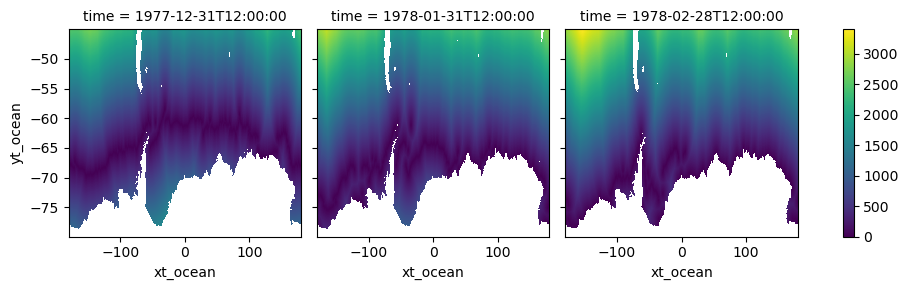

In [51]:
#Applying land mask
comp = dist_ice_edge.isel(time = slice(0, 3))
comp = xr.where(np.isnan(var_ice[0]), np.nan, comp)
comp.plot(col = 'time')

## Identifying areas north or south of the sea ice edge
We will follow these steps:
1. Identify the sea ice edge (grid cells with a value of `0`), and assign a value of `1`. All other grid cells are assigned a value of `0`.  
2. Calculate cumulative sums along latitude. This will identify areas south of the ice edge as `0`, and areas north of the edge as `1`.
3. Use cumulative sums as a mask, and multiply by `-1` any values within `0` grid cells. Otherwise, keep the same distance value.
4. Apply a land mask from model output.  

In [13]:
mask = xr.where(dist_ice_edge == dist_ice_edge.min('yt_ocean'), 1, 0).cumsum('yt_ocean')
dist_ice_edge_corr = xr.where(mask == 0, dist_ice_edge*-1, dist_ice_edge)
dist_ice_edge_corr = xr.where(np.isnan(var_ice), np.nan, dist_ice_edge_corr)

We can now compare the results with the absolute distances plotted above. We will add the sea ice edge too.

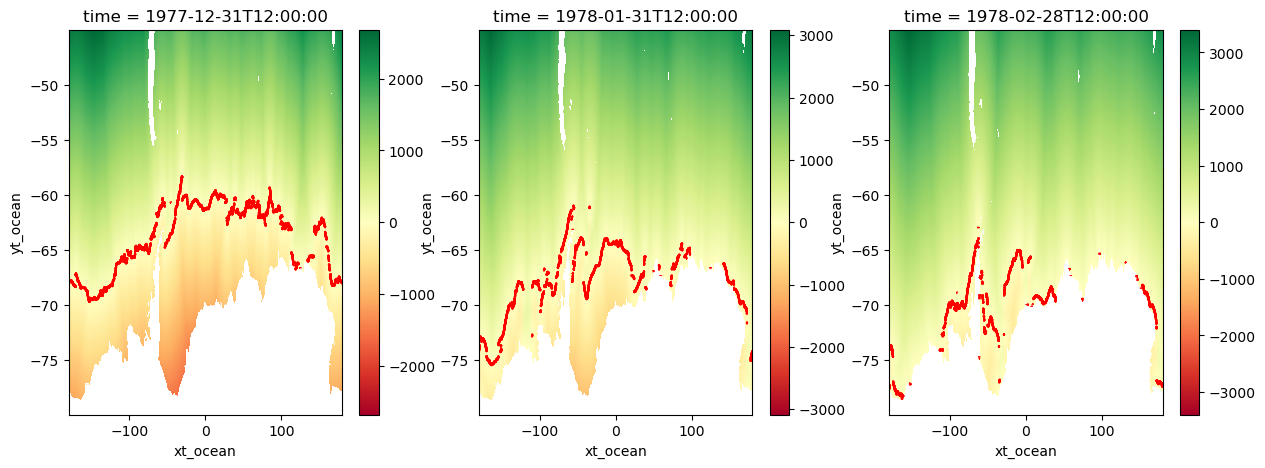

In [18]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
for i in range(0, 3):
    dist_ice_edge_corr.isel(time = i).plot(ax = axs[i], cmap = 'RdYlGn')
    ice_10.isel(time = i).plot.contour(ax = axs[i], colors = ['red'])

The reclassification of the data has been successful. Now areas south of the sea ice edge appear as negative distances, and areas north of the sea ice edge remain as positive values. 

# Saving data
We will rechunk data to match the model outputs so it is easier to manage in later steps and then save it to disk.

In [17]:
#Rechunking data
dist_ice_edge_corr = dist_ice_edge_corr.chunk((1, 270, 360))
#Renaming variable
dist_ice_edge_corr.name = 'dist_ice'

#Define output folder
out_folder = os.path.join(varDict['base_folder'], 'north_south')
os.makedirs(out_folder, exist_ok = True)

#Saving data per year
for yr, da in dist_ice_edge_corr.groupby('time.year'):
    out_name = f'Distance_Sea_Ice_Edge_{yr}.nc'
    da.to_netcdf(os.path.join(out_folder, out_name))